# Choke Performance
**Objective:** Calculate flow rates through wellhead chokes and determine flow regimes.

**Author:** Ade Anggi Naluriawan Santoso

The choke (or "bean") is a restriction at the wellhead that controls the production rate. It acts as the boundary condition between the Wellbore and the Surface Flowline.

**Why use a choke?**
1.  **Safety:** Protect downstream equipment from high reservoir pressure.
2.  **Reservoir Management:** Prevent sand production or water coning by limiting drawdown.
3.  **Flow Stability:** Maintain critical flow to prevent flow fluctuations (slugging).

In this notebook, we will:
1.  **Check for Critical Flow:** Determine if the flow velocity is sonic.
2.  **Calculate Flow Rate:** Use the **Gilbert Correlation** (the industry standard).
3.  **Generate Performance Curves:** Visualize how wellhead pressure relates to flow rate for different choke sizes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Flow Regimes: Sonic vs. Subsonic
Fluid flow through a choke can be in one of two regimes:

1.  **Critical (Sonic) Flow:** The fluid velocity reaches the speed of sound at the choke throat. Pressure disturbances downstream cannot travel upstream. The flow rate depends **only** on the upstream pressure ($P_{wh}$).
2.  **Sub-Critical (Subsonic) Flow:** The flow rate depends on the pressure drop across the choke ($P_{wh} - P_{line}$).

**The Critical Flow Check:**
For natural gas mixtures, flow is typically critical if the downstream pressure is roughly less than half the upstream pressure.
$$\frac{P_{line}}{P_{wh}} \le \left( \frac{2}{k+1} \right)^{\frac{k}{k-1}} \approx 0.546$$
*(For typical field gas with $k=1.3$, the ratio is approx 0.546. A general rule of thumb is 0.55 - 0.60)*

In [2]:
def check_flow_regime(p_upstream, p_downstream, k=1.3):
    """
    Checks if the flow through the choke is Critical (Sonic) or Sub-Critical.
    
    Parameters:
    p_upstream   : Wellhead Pressure (psia)
    p_downstream : Flowline Pressure (psia)
    k            : Specific heat ratio (Cp/Cv), typically 1.3 for natural gas
    
    Returns:
    tuple: (Status String, Critical Ratio)
    """
    # Calculate Theoretical Critical Ratio
    critical_ratio = (2 / (k + 1)) ** (k / (k - 1))
    
    actual_ratio = p_downstream / p_upstream
    
    if actual_ratio <= critical_ratio:
        return "Critical (Sonic)", critical_ratio
    else:
        return "Sub-Critical", critical_ratio

# --- TEST THE CHECK ---
p_wh = 800  # psia
p_line = 300 # psia

status, limit = check_flow_regime(p_wh, p_line)
print(f"Wellhead P: {p_wh} psi, Line P: {p_line} psi")
print(f"Ratio: {p_line/p_wh:.3f} (Limit: {limit:.3f})")
print(f"Flow Regime: {status}")

Wellhead P: 800 psi, Line P: 300 psi
Ratio: 0.375 (Limit: 0.546)
Flow Regime: Critical (Sonic)


## 2. Gilbert's Correlation
While there are rigorous physical models for choke flow, the oil industry relies heavily on empirical correlations. The most famous is by **Gilbert (1954)**, derived from data in the Ten Section Field in California.

**Gilbert's Equation (for Critical Flow):**
$$P_{wh} = \frac{435 \cdot R^{0.546} \cdot q}{S^{1.89}}$$

Rearranging to solve for Flow Rate ($q$):
$$q = \frac{P_{wh} \cdot S^{1.89}}{435 \cdot R^{0.546}}$$

Where:
* $P_{wh}$ = Upstream Wellhead Pressure (psia)
* $q$ = Gross Liquid Rate (stb/d)
* $R$ = Gas Liquid Ratio (Mcf/stb) **<-- Note the units! Mcf, not scf**
* $S$ = Choke Size (in 64ths of an inch)

In [3]:
def calc_rate_gilbert(p_wh, s_64, glr_scf):
    """
    Calculates liquid flow rate using Gilbert's Correlation.
    Assumes Critical Flow.
    
    Parameters:
    p_wh    : Wellhead Pressure (psia)
    s_64    : Choke size in 64ths of an inch (e.g. 32 for 32/64")
    glr_scf : Gas Liquid Ratio in scf/stb
    """
    # Convert GLR from scf/stb to Mcf/stb (kscf/stb) as required by Gilbert
    R = glr_scf / 1000.0
    
    # Gilbert Equation
    # q = (P * S^1.89) / (435 * R^0.546)
    numerator = p_wh * (s_64 ** 1.89)
    denominator = 435.0 * (R ** 0.546)
    
    q = numerator / denominator
    return q

# --- EXERCISE ---
# Scenario:
# We have a well with 600 psi pressure on a 32/64" choke.
# The GLR is 800 scf/stb.
# What is the production rate?

rate = calc_rate_gilbert(600, 32, 800)
print(f"Estimated Production Rate: {rate:.2f} stb/d")

Estimated Production Rate: 1089.70 stb/d


## 3. Comparison of Correlations
Gilbert is not the only one. **Ros (1960)** and **Achong (1961)** are also common.
* **Ros:** $P_{wh} = \frac{17.4 \cdot R^{0.5} \cdot q}{S^{2.0}}$
* **Achong:** $P_{wh} = \frac{3.82 \cdot R^{0.65} \cdot q}{S^{1.88}}$

Let's write a wrapper function to compare them.

In [4]:
def calc_choke_rate(p_wh, s_64, glr_scf, correlation='gilbert'):
    R = glr_scf / 1000.0
    
    if correlation == 'gilbert':
        # q = (P * S^1.89) / (435 * R^0.546)
        return (p_wh * (s_64 ** 1.89)) / (435.0 * (R ** 0.546))
    
    elif correlation == 'ros':
        # q = (P * S^2.0) / (17.4 * R^0.5)
        return (p_wh * (s_64 ** 2.0)) / (17.4 * (R ** 0.5))
        
    elif correlation == 'achong':
        # q = (P * S^1.88) / (3.82 * R^0.65)
        return (p_wh * (s_64 ** 1.88)) / (3.82 * (R ** 0.65))
    
    else:
        return 0.0

# Compare results
corrs = ['gilbert', 'ros', 'achong']
print("Comparison for P=600 psi, S=32/64, GLR=800:")
for c in corrs:
    q = calc_choke_rate(600, 32, 800, c)
    print(f"  {c.capitalize()}: {q:.2f} stb/d")

Comparison for P=600 psi, S=32/64, GLR=800:
  Gilbert: 1089.70 stb/d
  Ros: 39478.17 stb/d
  Achong: 122676.49 stb/d


## 4. Choke Performance Curves
Production engineers often use "Performance Curves" to select the right choke size. We plot **Wellhead Pressure ($P_{wh}$)** vs **Liquid Rate ($q$)** for various choke sizes.

This plot answers the question: *"If I want to produce 1000 bbl/d, and my wellhead pressure is 500 psi, what choke size do I need?"*

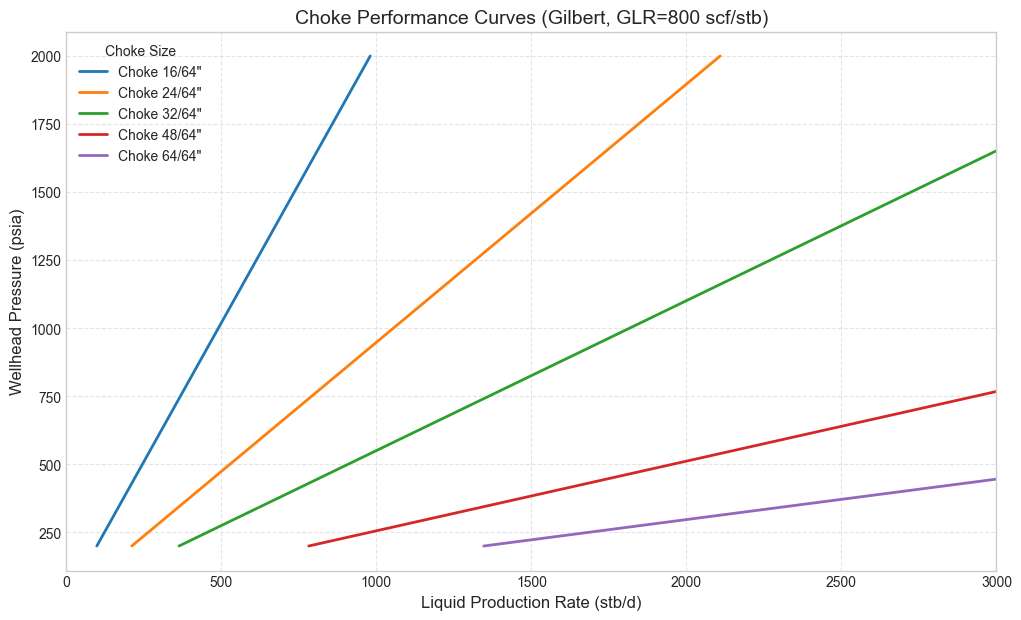

In [6]:
# Range of Pressures (200 to 2000 psi)
pressures = np.linspace(200, 2000, 50)

# Common Choke Sizes (in 64ths)
choke_sizes = [16, 24, 32, 48, 64]
glr_scenario = 800 # scf/stb

plt.figure(figsize=(12, 7))

for s in choke_sizes:
    # Calculate rates for this choke size across all pressures
    rates = [calc_choke_rate(p, s, glr_scenario, 'gilbert') for p in pressures]
    
    plt.plot(rates, pressures, label=f'Choke {s}/64"', linewidth=2)

plt.title(f"Choke Performance Curves (Gilbert, GLR={glr_scenario} scf/stb)", fontsize=14)
plt.xlabel("Liquid Production Rate (stb/d)", fontsize=12)
plt.ylabel("Wellhead Pressure (psia)", fontsize=12)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title="Choke Size")
plt.xlim(0, 3000)

plt.show()

## Summary
1.  **Critical Flow:** Essential for stable production. We checked this using the pressure ratio ($P_{line}/P_{wh} \approx 0.55$).
2.  **Gilbert:** The "Go-To" correlation for sizing chokes.
3.  **Visualization:** The performance curves show that for a fixed pressure, opening the choke (increasing size) increases the rate non-linearly.

**Next Step:**
In **Chapter 6**, we will combine this Surface Calculation with the IPR (Chapter 3) and TPR (Chapter 4) to perform full System Analysis.